<a href="https://colab.research.google.com/github/sarvesh23110076/srip_selection_task/blob/main/srip_NB_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# IMPORTANT: SOME KAGGLE DATA SOURCES ARE PRIVATE
# RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES.
import kagglehub
kagglehub.login()


In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

sarveshchaudhari9325_srip_dataset_path = kagglehub.dataset_download('sarveshchaudhari9325/srip-dataset')

print('Data source import complete.')



# ***IIT GN's SUMMER RESEARCH INTERNSHIP PROJECT***<BR><BR> ***SRIP PROJECT NUMBER: IP0NB0000019***
# ***NAME: SARVESH PRAVIN CHAUDHARI***

# Selection Task

In [ ]:
from PIL import Image
import os
import torch
import torchvision
import numpy as np
from einops import rearrange

# ***Dataset:***

In [ ]:
images_folder_path="/kaggle/input/srip-dataset/image_chips_native-20250212T103727Z-001/image_chips_native"
labels_folder_path_native="/kaggle/input/srip-dataset/labels-20250212T103318Z-001/labels/labels_native"

In [ ]:
def create_images_folder(path1,path2):
    images_folder=os.listdir(os.path.join(path1))
    labels_folder=os.listdir(os.path.join(path2))

    X,y=[],[]
    for image_path in images_folder:
        label_path=image_path[:-4]+'.txt'
        if label_path in labels_folder:
            image=Image.open(os.path.join(path1,image_path))
            image=torch.tensor(np.array(image)).float()/255.0
            image=rearrange(image,'h w c->c h w')
            X.append(image)
            y.append(os.path.join(path2,label_path))

    return torch.stack(X),y

def create_labels_folder(labels_folder):
    labels=[]

    for label_path in labels_folder:
        labelpath=os.path.join(label_path)

        with open(labelpath,"r") as data:
            lines=data.readlines()
        data=[]

        for line in lines:
            values=line.strip().split()
            class_label=int(values[0])
            bbox=list(map(float,values[1:]))
            data.append([class_label]+bbox)
        labels.append(torch.tensor(data))

    return labels

In [ ]:
Images,Labels_folder=create_images_folder(images_folder_path,labels_folder_path_native)
Labels=create_labels_folder(Labels_folder)

# ***Data Exploration and Understanding***

# **1.Dataset Statistics**

# 1. a. How many instances of solar panels are present in the dataset?

In [ ]:
def get_number_of_instances(folder):
    count=0
    for label in folder:
        count+=label.shape[0]
    return count

In [ ]:
instances=get_number_of_instances(Labels)
print(f"Number of instances of solar panels present in the dataset: {instances}")

Number of instances of solar panels present in the dataset: 29625


# 1. b. Compute and show the value counts of labels per image. E.g., X images have 0 labels, Y images have 1 label, … and so on.

In [ ]:
import pandas as pd

def get_label_count(folder):
    label_count_dic={}
    for label in folder:
        numoflabels=label.shape[0]
        if numoflabels in label_count_dic:
            label_count_dic[numoflabels]+=1
        else:
            label_count_dic[numoflabels]=1
    label_count_dic=dict(sorted(label_count_dic.items()))
    label_table=pd.DataFrame(list(label_count_dic.items()),columns=["Number of Labels","Count of Images"])
    return label_table

Label_count_table=get_label_count(Labels).set_index('Number of Labels')

In [ ]:
Label_count_table

,Count of Images
Number of Labels,
1,81
2,167
3,221
4,218
5,217
...,...
74,5
75,1
76,2


# **2. Calculate the statistics of the area of solar panels in meters**

# 2. a. What method was used to compute the area (in meters) for a single instance?


1. The pixels are normalized according to size=416
   - therefore, denormalizing to orginal pixel size:de_x_width=(x_width*416)
   - Now, each pixel represents to 0.31 meters
   - therefore origal sizes are given as
   - width=de_x_width*0.31
   - height=de_x_height*0.31
   - area = width* height

# 2. b. What is the mean area and standard deviation?

In [ ]:
def area_operator_function(data,pixels=416,in_meters=0.31):

    (class_id,xcen,ycen,width,height)=(element.item() for element in data)
    (de_normalized_width,de_normalized_height)=(width*pixels,height*pixels)
    (width_meters,height_meters)=(de_normalized_width*in_meters,de_normalized_height*in_meters)
    area=width_meters*height_meters

    return int(class_id),area

def get_area(folder):

    area_store={}
    for labels in folder:
        for label in labels:
            class_id_get,area_get=area_operator_function(label)
            if class_id_get not in area_store:
                area_store[class_id_get]=[]
            area_store[class_id_get].append(area_get)

    return dict(sorted(area_store.items()))

def get_area_statistics(storage):

    area_statistics={
        "mean_area":[],
        "standard_deviation":[]
    }

    indices=[]
    for class_id in storage:
        area_statistics["mean_area"].append(np.mean(storage[class_id]))
        area_statistics["standard_deviation"].append(np.std(storage[class_id]))
        indices.append(f"Class {class_id}")

    return pd.DataFrame(area_statistics,index=indices)

area=get_area(Labels)
area_stats=get_area_statistics(area)
print(f"Mean area and Standard Deviation for each class in meter per square:\n {area_stats}")


Mean area and Standard Deviation for each class in meter per square:
           mean_area  standard_deviation
Class 0  192.654728          634.279262
Class 1  157.841294          193.172641
Class 2   64.782359           72.795696


# 2. c. Plot the histogram of areas. What do you observe?

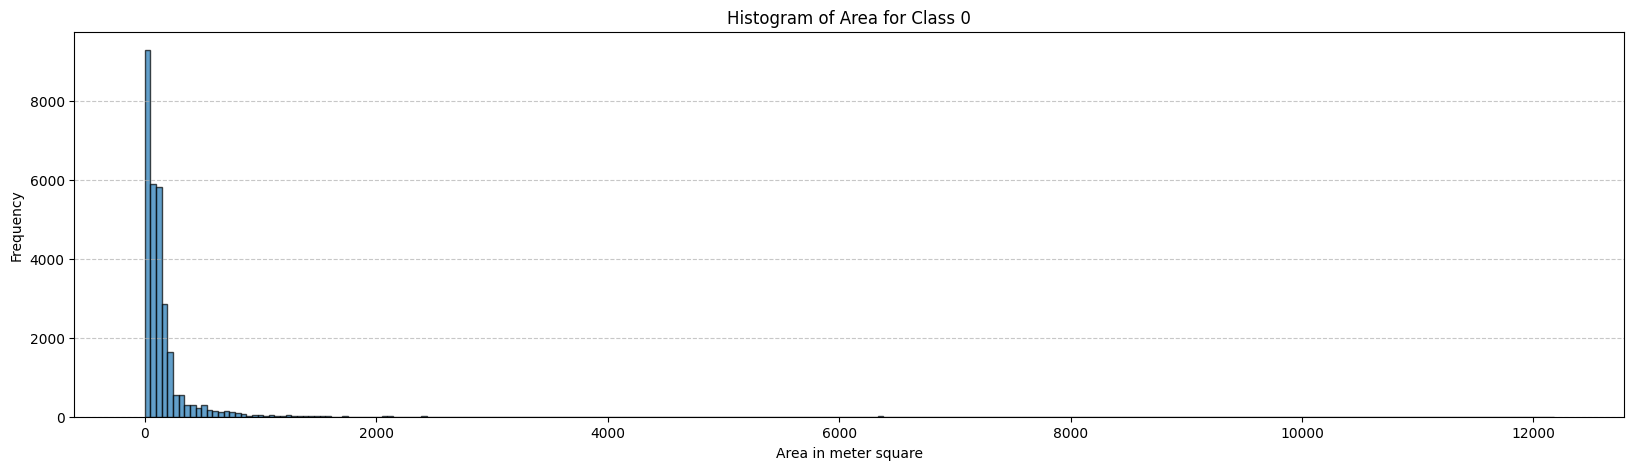

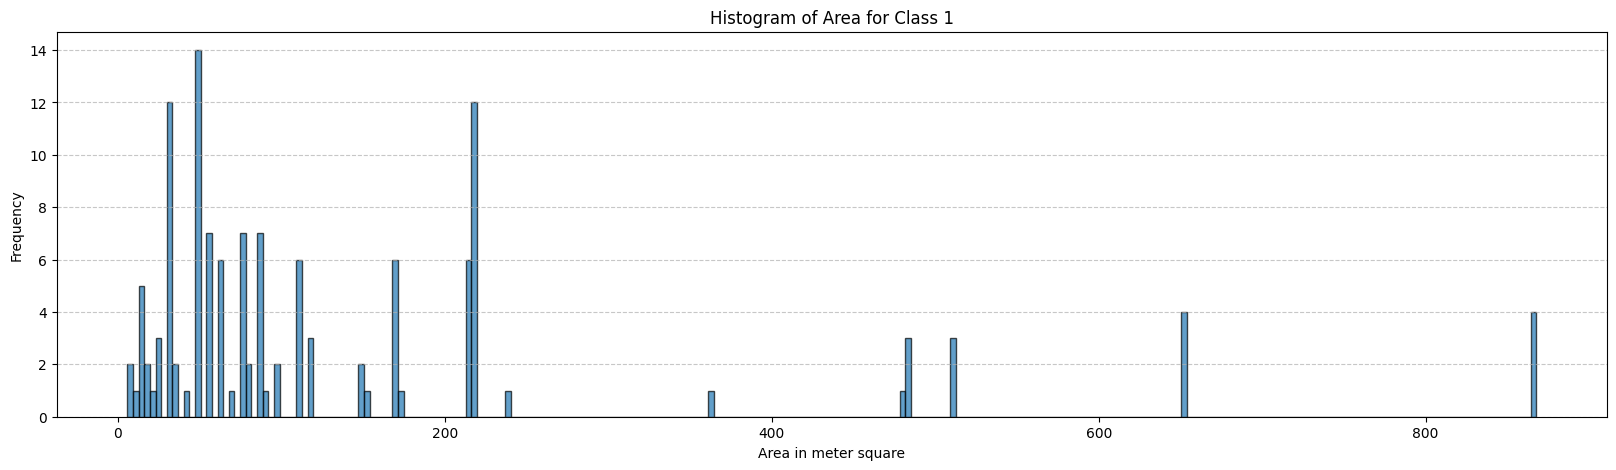

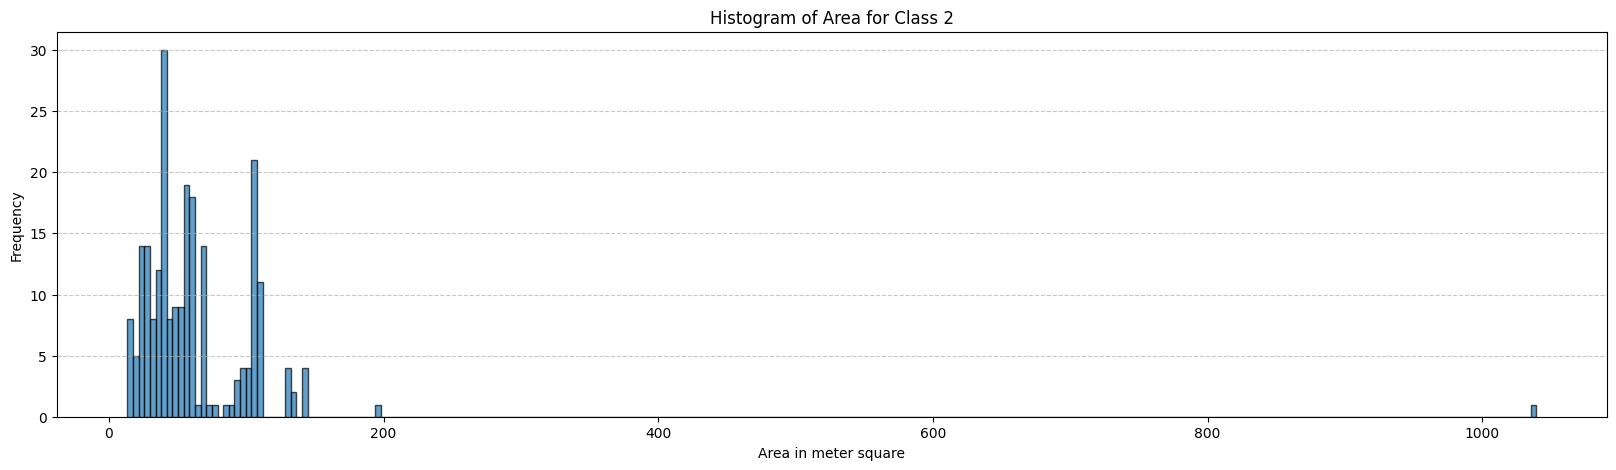

In [ ]:
import matplotlib.pyplot as plt

def create_histogram(storage,get_id):
    plt.figure(figsize=(20,5))
    plt.hist(np.array(storage),bins=250,edgecolor='black',alpha=0.7)
    plt.xlabel("Area in meter square")
    plt.ylabel("Frequency")
    plt.title(f"Histogram of Area for Class {get_id}")
    plt.grid(axis='y',linestyle='--',alpha=0.7)
    plt.show()

def histogram_operator_function(labels_storage):
    for class_id in labels_storage:
        create_histogram(labels_storage[class_id],class_id)

histogram_operator_function(area)

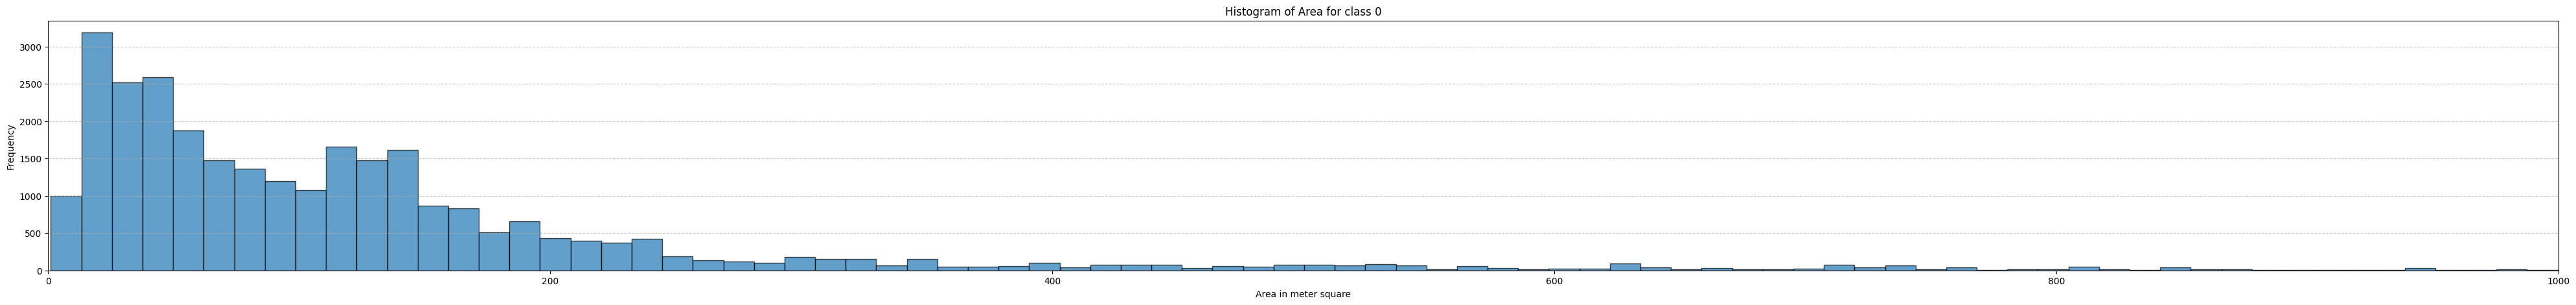

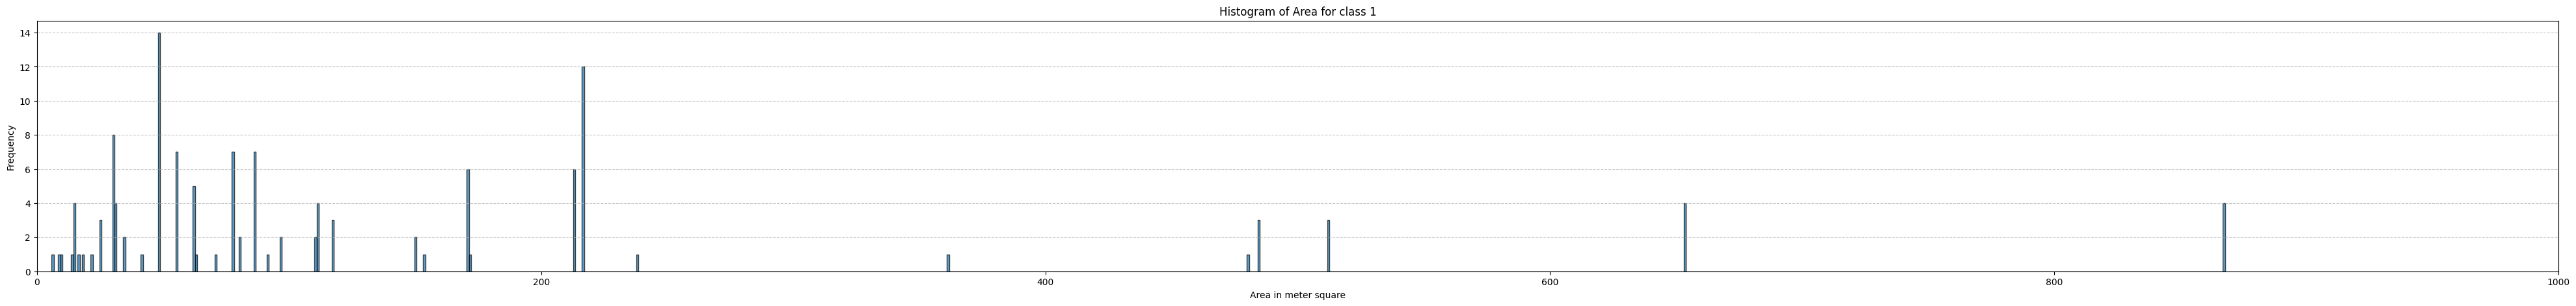

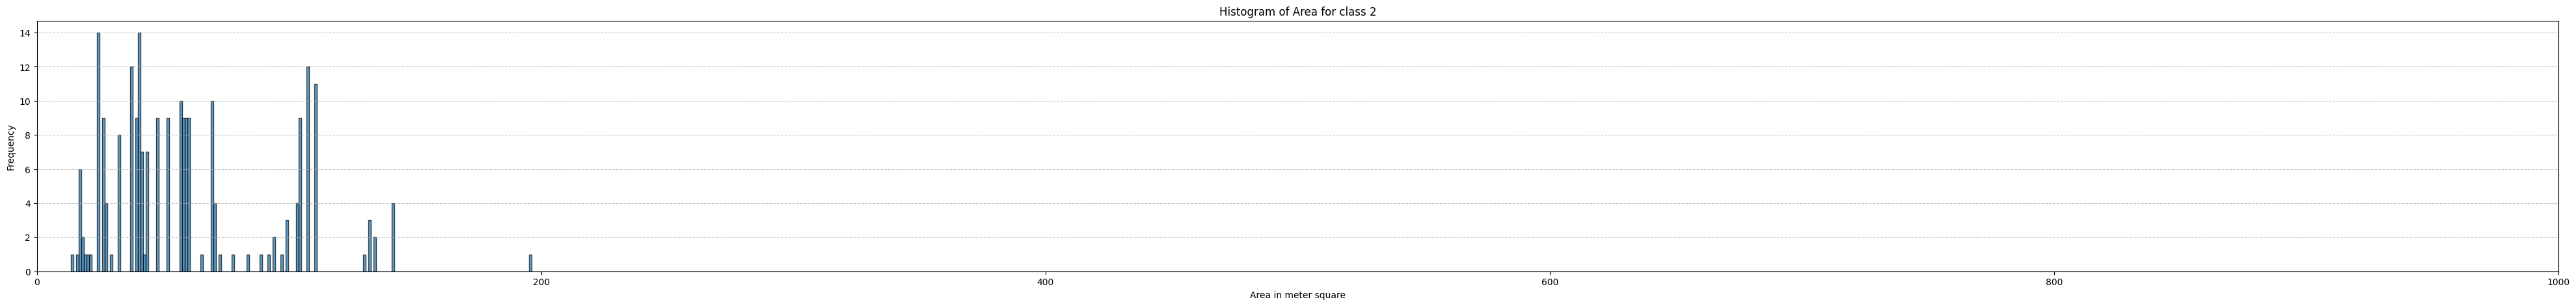

In [ ]:
def create_histogram(storage,get_id):
    plt.figure(figsize=(50,5))
    plt.hist(np.array(storage),bins=1000,edgecolor='black',alpha=0.7)
    plt.xlabel("Area in meter square")
    plt.ylabel("Frequency")
    plt.xlim(left=0,right=1000)
    plt.title(f"Histogram of Area for class {get_id}")
    plt.grid(axis='y',linestyle='--',alpha=0.7)
    plt.show()

def histogram_operator_function(labels_storage):
    for class_id in labels_storage:
        create_histogram(labels_storage[class_id],class_id)

histogram_operator_function(area)

from the histogram resulted ..it can be stated that the class 0 is frequently occuring class with an mean average area of 192 m square included area of classes to the range upto 10000 then class 2 consists of solar panels corresponding to the areas with mean average area of 64 ...the class 1 consists of area of low range as well as of some solar panels with large area with mean average area 157

# ***Implementing the Fundamental Functions***

# **1. Write a function to compute IoU (Intersection over Union) between two axis-aligned bounding boxes specified in the Ultralytics YOLO format. You MUST use the shapely library and its functionalities to write your function. Show that your function provides the same or similar answer as IoU computed using `supervision` library**

In [ ]:
def generate_yolo_format_box(instance=3,size=416,box_size=30):

    class_id=np.random.randint(0,instances)
    (x1,y1)=(np.random.randint(0,size-1),np.random.randint(0,size-1))
    (x2,y2)=(x1+box_size,y1+box_size)

    x_center=(x1+x2)/2.0
    x_center=x_center/size

    y_center=(y1+y2)/2.0
    y_center=y_center/size

    (width,height)=((x2-x1)/size,(y2-y1)/size)

    return f"{class_id} {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}"

def get_yolo_format(box):
    values=box.split()
    bbox=list(map(float,values[1:]))
    return bbox

def generate_intersecting_box(box,xc_shift=0.00001,yc_shift=0.00001,scale_width=0.1,scale_height=0.1):
    x_center,y_center,width,height=box
    return [x_center+xc_shift,y_center+yc_shift,width*scale_width,height*scale_height]

In [ ]:
from shapely.geometry import Polygon

def get_polygon_format(box):
    x_center,y_center,width,height=box
    x_min=x_center-width/2
    y_min=y_center-height/2
    x_max=x_center+width/2
    y_max=y_center+height/2

    return Polygon([(x_min,y_min),(x_max,y_min),(x_max,y_max),(x_min,y_max)])

def IoU_computor(box1,box2):
    (box1,box2)=(get_polygon_format(box1),get_polygon_format(box2))

    intersection=box1.intersection(box2).area
    union=box1.union(box2).area

    iou= intersection/ union if union!=0 else 0
    return iou

In [ ]:
!pip install supervision

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.5/181.5 kB 4.1 MB/s eta 0:00:00a 0:00:01


In [ ]:
from shapely.geometry import Polygon
import supervision as sv
import numpy as np

In [ ]:
def conversion_supervision(box):
    x,y,w,h=box
    return [x-w/2,y-h/2,x+w/2,y+h/2]

def IoU_computor_supervision(box1,box2):
    (box1,box2)=(conversion_supervision(box1),conversion_supervision(box2))
    return sv.box_iou_batch(np.array([box1]),np.array([box2]))[0][0]

In [ ]:
bbox1=get_yolo_format(generate_yolo_format_box())
bbox2=generate_intersecting_box(bbox1)

iou_1=IoU_computor(bbox1,bbox2)
iou_2=IoU_computor_supervision(bbox1,bbox2)

print(f"IoU values computed using implemented function: {iou_1}")
print(f"IoU values computed supervision library function: {iou_2}")

IoU values computed using implemented function: 0.009999999999999953
IoU values computed supervision library function: 0.009999999999999953


# **2. Write a function to compute Average Precision (AP)**

In [ ]:
def get_precision_recall_function(truth_value,predict_value,iou_threshold):
    TP,FP=0,0
    matched=[False]*len(predict_value)
    for truthbox in truth_value:
        matched=False
        for i,predictbox in enumerate(predict_value):
            iou_value=IoU_computor(truthbox,predictbox)
            if iou_value>=iou_threshold:
                TP+=1
                matched=True
                break
        if not matched:
            FP+=1

    precision_value=TP/(TP+FP) if (TP+FP)>0 else 0
    recall_value=TP/len(truth_value) if len(truth_value)>0 else 0

    return (precision_value,recall_value)

def get_precision_recall(truth_values,predict_values,iou_threshold):
    (precision_data,recall_data)=[],[]
    for truth_box,predict_box in zip(truth_values,predict_values):
        precision,recall=get_precision_recall_function(truth_box,predict_box,iou_threshold)
        precision_data.append(precision)
        recall_data.append(recall)
    return np.array(precision_data),np.array(recall_data)

# 2. a. Use Pascal VOC 11 point interpolation method to implement the function

In [ ]:
def pascal_voc_11_point_interpolation(truth_values,predict_values,iou_threshold):
    precision,recall=get_precision_recall(truth_values,predict_values,iou_threshold)
    recall_levels=np.linspace(0,1,11)
    interpolated_precision=[]
    for r in recall_levels:
        precision_at_recall=[p for p,rec, in zip(precision,recall) if rec>=r]
        if not precision_at_recall:
            interpolated_precision.append(0)
        else:
            interpolated_precision.append(max(precision_at_recall))
    return np.mean(interpolated_precision)

# 2. b. Use COCO 101-point interpolation method to implement the function

In [ ]:
def coco_101_point_interpolation(truth_values,predict_values,iou_threshold):
    precision,recall=get_precision_recall(truth_values,predict_values,iou_threshold)
    recall_levels=np.linspace(0,1,101)
    interpolated_precision=[]
    for r in recall_levels:
        precision_at_recall=[p for p,rec, in zip(precision,recall) if rec>=r]
        if not precision_at_recall:
            interpolated_precision.append(0)
        else:
            interpolated_precision.append(max(precision_at_recall))
    return np.mean(interpolated_precision)

# 2. c. Use Area under Precision-Recall Curve (AP) method to implement the function

In [ ]:
def area_under_precision_recall_curve(truth_values,predict_values,iou_threshold):
    precision,recall=get_precision_recall(truth_values,predict_values,iou_threshold)

    sorted_indices=np.argsort(recall)
    recall=recall[sorted_indices]
    precision=precision[sorted_indices]

    precision=np.concatenate(([1],precision,[0]))
    recall=np.concatenate(([0],recall,[1]))

    for i in range(len(precision)-2,-1,-1):
        precision[i]=max(precision[i],precision[i+1])

    ap = np.sum((recall[1:] - recall[:-1]) * precision[1:])
    return ap

# 2. d. Randomly generate 10 images of size 100x100. Randomly generate 10 ground truth boxes of size 20x20 and 10 predicted boxes of size 20x20 in each image. Assume there is only one class of objects. Compare the AP50 (Average Precision at IoU 0.5) computed by 3 of your methods

In [ ]:
def generate_image(size):
    return np.random.rand(size,size)

def generate_box(nbbox,size,box_size,type='truth',box_data=None):
    data=[]
    if type=='truth':
        for _ in range(nbbox):
            for _ in range(100):
                (x1,y1)=np.random.randint(0,size-1,2)
                (x2,y2)=(x1+box_size,y1+box_size)
                if (x2<size and y2<size):
                    break
                else:
                    continue

            (x_center,y_center)=((x1+x2)/2.0,(y1+y2)/2.0)
            (x_center,y_center)=(x_center/size,y_center/size)
            (width,height)=(box_size/size,box_size/size)
            data.append([x_center,y_center,width,height])
        return np.array(data)

    if type=='predict':
        for boxes in box_data:
            for _ in range(100):
                x_shift,y_shift=np.random.uniform(-0.1,0.1,size=2)
                x_center,y_center,width,height=boxes
                x_center+=x_shift
                y_center+=y_shift
                x1,x2,y1,y2=(x_center-width/2,x_center+width/2,y_center-height/2,y_center+height/2)
                if ((x1>=0 and x1<1) and (x2>=0 and x2<1) and (y1>=0 and y1<1) and (y2>=0 and y2<1)):
                    data.append([x_center,y_center,width,height])
                    break
        return np.array(data)

In [ ]:
def compute_mAP50(truth_values,predict_values,method):
    iou_threshold=0.5
    if method=="Pascal_voc_11_point_interpolation":
        return pascal_voc_11_point_interpolation(truth_values,predict_values,iou_threshold)
    elif method=="Coco_101_point_interpolation":
        return coco_101_point_interpolation(truth_values,predict_values,iou_threshold)
    else:
        return area_under_precision_recall_curve(truth_values,predict_values,iou_threshold)

In [ ]:
number_of_images=10
number_of_box=10

get_images=np.array([generate_image(100) for _ in range(number_of_images)])
truth_boxes=np.array([generate_box(number_of_box,100,20) for _ in range(number_of_images)])
predict_boxes=np.array([generate_box(number_of_box,100,20,'predict',truth_boxes[i]) for i in range(number_of_images)])

method1_mAP50=compute_mAP50(truth_boxes,predict_boxes,"Pascal_voc_11_point_interpolation")
method2_mAP50=compute_mAP50(truth_boxes,predict_boxes,"Coco_101_point_interpolation")
method3_mAP50=compute_mAP50(truth_boxes,predict_boxes,"Area_under_Precision_Recall_curve")

dic={
    'Methods':["Pascal_voc_11_point_interpolation","Coco_101_point_interpolation","Area_under_Precision_Recall_curve"],
    'mAP50_value':[method1_mAP50,method2_mAP50,method3_mAP50]
}
result=pd.DataFrame(dic).set_index('Methods')
result

,mAP50_value
Methods,
Pascal_voc_11_point_interpolation,0.327273
Coco_101_point_interpolation,0.362376
Area_under_Precision_Recall_curve,0.360000


# ***Model building and evaluation***

# **Dataset preparation:<BR>Split the data into 80-20 train-test split. Use 10% of training data as validation.**

In [ ]:
image_file_path=os.path.join("/kaggle/input/srip-dataset/image_chips_native-20250212T103727Z-001/image_chips_native")
label_file_path=os.path.join("/kaggle/input/srip-dataset/labels-20250212T103318Z-001/labels/labels_native")

In [ ]:
import shutil
from sklearn.model_selection import train_test_split

def copy_files(file_paths,destination_folder,convert_to_jpg=False):
    for file_path in file_paths:
        file_name=os.path.basename(file_path)
        if convert_to_jpg:
            file_name=file_name.replace(".tif",".jpg")
            destination_path=os.path.join(destination_folder,file_name)
            image=Image.open(file_path)
            image.convert("RGB").save(destination_path,"JPEG")
        else:
            destination_path=os.path.join(destination_folder,file_name)
            shutil.copy(file_path,destination_path)

def create_dataset(path1,path2):

    image_folder=os.listdir(os.path.join(path1))
    label_folder=os.listdir(os.path.join(path2))

    new_image_folder,new_label_folder=[],[]

    for image_path in image_folder:
        label_path=image_path[:-4]+'.txt'
        if label_path in label_folder:
            new_image_folder.append(os.path.join(path1,image_path))
            new_label_folder.append(os.path.join(path2,label_path))

    X_train,X_test,y_train,y_test=train_test_split(new_image_folder,new_label_folder,test_size=0.2,random_state=42)
    X_train,X_valid,y_train,y_valid=train_test_split(X_train,y_train,test_size=0.2,random_state=42)

    dataset_path="dataset"
    images_path=os.path.join(dataset_path,"images")
    labels_path=os.path.join(dataset_path,"labels")

    os.makedirs(os.path.join(images_path,"train"),exist_ok=True)
    os.makedirs(os.path.join(images_path,"val"),exist_ok=True)
    os.makedirs(os.path.join(images_path,"test"),exist_ok=True)
    os.makedirs(os.path.join(labels_path,"train"),exist_ok=True)
    os.makedirs(os.path.join(labels_path,"val"),exist_ok=True)
    os.makedirs(os.path.join(labels_path,"test"),exist_ok=True)

    copy_files(X_train,os.path.join(images_path,"train"),True)
    copy_files(y_train,os.path.join(labels_path,"train"))

    copy_files(X_valid,os.path.join(images_path,"val"),True)
    copy_files(y_valid,os.path.join(labels_path,"val"))

    copy_files(X_test,os.path.join(images_path,"test"),True)
    copy_files(y_test,os.path.join(labels_path,"test"))

    dataset_yaml_content=f"""
    path: {os.path.abspath(dataset_path)}
    train: images/train
    val: images/val
    test: images/test

    nc: 3
    names: ['Class_0','Class_1','Class_2']
    """

    with open(os.path.join(dataset_path,"dataset.yaml"),"w") as f:
        f.write(dataset_yaml_content)

In [ ]:
create_dataset(image_file_path,label_file_path)

# **1. Use any model from Ultralytics like YOLO to train the object detection model. Show that validation loss is converged.**

In [ ]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 922.1/922.1 kB 15.9 MB/s eta 0:00:0000:01


In [ ]:
from ultralytics import YOLO
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model=YOLO("yolov8s.pt")

dataset_path="/kaggle/working/dataset"
results=model.train(
    data=os.path.join(dataset_path,"dataset.yaml"),
    epochs=100,
    batch=16,
    imgsz=416,
    val=True,
    device=device,
    patience=10
)

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


100%|██████████| 21.5M/21.5M [00:00<00:00, 131MB/s] 


engine/trainer: task=detect, mode=train, model=yolov8s.pt, data=/kaggle/working/dataset/dataset.yaml, epochs=100, time=None, patience=10, batch=16, imgsz=416, save=True, save_period=-1, cache=False, device=cuda, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True, line_width=None, format=torchscript, keras=False, optimize=False,

100%|██████████| 755k/755k [00:00<00:00, 18.2MB/s]


Overriding model.yaml nc=80 with nc=3

                   from  n    params  module                                       arguments                     
  0                  -1  1       928  ultralytics.nn.modules.conv.Conv             [3, 32, 3, 2]                 
  1                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  2                  -1  1     29056  ultralytics.nn.modules.block.C2f             [64, 64, 1, True]             
  3                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  4                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  5                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128, 256, 3, 2]              
  6                  -1  2    788480  ultralytics.nn.modules.block.C2f             [256, 256, 2, True]           
  7                  -1  1   1180672  ultralytics

100%|██████████| 5.35M/5.35M [00:00<00:00, 76.2MB/s]


AMP: checks passed ✅


train: Scanning /kaggle/working/dataset/labels/train... 1626 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1626/1626 [00:01<00:00, 946.78it/s]


train: New cache created: /kaggle/working/dataset/labels/train.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Scanning /kaggle/working/dataset/labels/val... 407 images, 0 backgrounds, 0 corrupt: 100%|██████████| 407/407 [00:00<00:00, 856.14it/s]

val: New cache created: /kaggle/working/dataset/labels/val.cache


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001429, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 416 train, 416 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      1.89G      1.818      1.857      1.315         92        416: 100%|██████████| 102/102 [00:23<00:00,  4.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:04<00:00,  2.65it/s]

                   all        407       4851      0.574      0.215      0.238      0.138



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      1.92G      1.466      1.045      1.126        162        416: 100%|██████████| 102/102 [00:21<00:00,  4.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  3.99it/s]

                   all        407       4851      0.893      0.218      0.218      0.137



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      1.86G      1.447     0.9983      1.121        170        416: 100%|██████████| 102/102 [00:20<00:00,  4.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  4.00it/s]


                   all        407       4851      0.918      0.231      0.266      0.166

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100       1.8G      1.386     0.9413      1.093        131        416: 100%|██████████| 102/102 [00:21<00:00,  4.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  4.10it/s]


                   all        407       4851      0.932      0.257      0.313      0.192

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      2.13G       1.35     0.9098      1.084         88        416: 100%|██████████| 102/102 [00:21<00:00,  4.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  4.02it/s]


                   all        407       4851       0.93       0.26       0.32      0.208

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      2.01G      1.302     0.8711      1.062        127        416: 100%|██████████| 102/102 [00:21<00:00,  4.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  4.14it/s]


                   all        407       4851      0.743      0.351      0.359      0.232

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      1.86G      1.253     0.8058      1.043        120        416: 100%|██████████| 102/102 [00:20<00:00,  4.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  4.08it/s]


                   all        407       4851      0.789      0.351      0.353       0.24

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      1.91G      1.267     0.8215      1.049        129        416: 100%|██████████| 102/102 [00:20<00:00,  4.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  4.06it/s]


                   all        407       4851      0.904      0.306       0.37      0.246

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      1.98G      1.244     0.8093       1.04        169        416: 100%|██████████| 102/102 [00:20<00:00,  4.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  4.07it/s]


                   all        407       4851      0.937      0.305      0.398      0.271

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      1.98G      1.221     0.8013      1.032        168        416: 100%|██████████| 102/102 [00:21<00:00,  4.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  4.13it/s]


                   all        407       4851      0.748      0.377       0.43      0.292

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      1.98G      1.206     0.7694      1.025        136        416: 100%|██████████| 102/102 [00:20<00:00,  4.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  4.18it/s]


                   all        407       4851      0.844      0.412      0.483      0.331

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      2.03G      1.203      0.752      1.016        191        416: 100%|██████████| 102/102 [00:20<00:00,  4.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  4.12it/s]


                   all        407       4851       0.75      0.482      0.494      0.327

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      1.92G       1.17     0.7319      1.005        155        416: 100%|██████████| 102/102 [00:20<00:00,  4.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  4.17it/s]


                   all        407       4851       0.61      0.483      0.454      0.314

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      1.98G      1.163     0.7346      1.005        171        416: 100%|██████████| 102/102 [00:21<00:00,  4.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  4.06it/s]


                   all        407       4851      0.899      0.419      0.497      0.351

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      1.97G      1.158     0.7228      1.002        212        416: 100%|██████████| 102/102 [00:20<00:00,  4.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  4.16it/s]


                   all        407       4851      0.838      0.481      0.547      0.381

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      1.78G       1.12     0.6964     0.9855        263        416: 100%|██████████| 102/102 [00:20<00:00,  4.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  3.98it/s]


                   all        407       4851      0.709      0.505      0.557      0.399

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      1.98G      1.138     0.7086     0.9879         98        416: 100%|██████████| 102/102 [00:20<00:00,  4.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  4.16it/s]


                   all        407       4851      0.772      0.464      0.576      0.381

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      1.94G      1.111     0.6881      0.987        139        416: 100%|██████████| 102/102 [00:20<00:00,  4.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  4.07it/s]


                   all        407       4851      0.707      0.555       0.59      0.392

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      1.91G      1.119     0.7027     0.9848        154        416: 100%|██████████| 102/102 [00:21<00:00,  4.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  4.11it/s]


                   all        407       4851      0.678      0.509      0.578       0.39

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      1.89G      1.081     0.6635     0.9742        129        416: 100%|██████████| 102/102 [00:20<00:00,  4.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  4.15it/s]


                   all        407       4851      0.816      0.575      0.669      0.471

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      2.12G      1.085     0.6775     0.9709        126        416: 100%|██████████| 102/102 [00:20<00:00,  4.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  4.08it/s]


                   all        407       4851       0.76      0.592       0.63      0.422

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      1.98G       1.07     0.6646     0.9673         70        416: 100%|██████████| 102/102 [00:20<00:00,  4.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  4.10it/s]


                   all        407       4851      0.892      0.572      0.668       0.47

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100       1.9G      1.073     0.6611     0.9698        126        416: 100%|██████████| 102/102 [00:20<00:00,  4.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  4.24it/s]


                   all        407       4851      0.667      0.732       0.74      0.487

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      1.99G      1.066     0.6549      0.964        115        416: 100%|██████████| 102/102 [00:21<00:00,  4.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  4.18it/s]


                   all        407       4851      0.676      0.673      0.677      0.464

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      1.98G      1.059      0.657     0.9647        215        416: 100%|██████████| 102/102 [00:20<00:00,  4.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  4.18it/s]


                   all        407       4851      0.811      0.654      0.714      0.481

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      2.26G      1.056     0.6455     0.9649        171        416: 100%|██████████| 102/102 [00:20<00:00,  4.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  4.19it/s]


                   all        407       4851      0.848      0.661      0.722      0.506

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      1.86G      1.031     0.6259     0.9553        210        416: 100%|██████████| 102/102 [00:20<00:00,  4.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  4.15it/s]


                   all        407       4851      0.781      0.658      0.713      0.506

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100       2.1G       1.05     0.6354     0.9601        294        416: 100%|██████████| 102/102 [00:20<00:00,  4.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  4.16it/s]


                   all        407       4851      0.862      0.686      0.749      0.525

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100       1.9G      1.025     0.6191     0.9546        190        416: 100%|██████████| 102/102 [00:21<00:00,  4.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  4.14it/s]


                   all        407       4851      0.897      0.592      0.705      0.493

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      1.97G       1.02     0.6121     0.9491        149        416: 100%|██████████| 102/102 [00:20<00:00,  4.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  3.98it/s]


                   all        407       4851      0.802      0.665      0.728      0.525

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      2.04G      1.004     0.6115     0.9489        200        416: 100%|██████████| 102/102 [00:20<00:00,  4.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  4.13it/s]


                   all        407       4851      0.863       0.62      0.734      0.506

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      1.96G     0.9971     0.6001     0.9471        117        416: 100%|██████████| 102/102 [00:21<00:00,  4.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  4.20it/s]


                   all        407       4851      0.841      0.664      0.778      0.557

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      2.16G     0.9861     0.5928      0.942        146        416: 100%|██████████| 102/102 [00:20<00:00,  4.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  4.26it/s]


                   all        407       4851      0.677      0.706      0.757      0.542

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      2.08G     0.9655     0.5806     0.9413         90        416: 100%|██████████| 102/102 [00:21<00:00,  4.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  4.18it/s]


                   all        407       4851      0.894      0.673      0.816       0.58

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      1.93G     0.9809     0.5914     0.9356        177        416: 100%|██████████| 102/102 [00:20<00:00,  4.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  4.21it/s]

                   all        407       4851      0.897      0.725       0.78       0.56



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      1.99G      0.966     0.5777     0.9358        157        416: 100%|██████████| 102/102 [00:20<00:00,  4.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  4.20it/s]


                   all        407       4851      0.948       0.76      0.798      0.566

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      1.95G     0.9666     0.5865      0.938        108        416: 100%|██████████| 102/102 [00:21<00:00,  4.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  4.15it/s]


                   all        407       4851      0.899      0.743      0.815      0.608

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      1.78G     0.9503      0.572     0.9332        146        416: 100%|██████████| 102/102 [00:21<00:00,  4.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  4.17it/s]


                   all        407       4851      0.942        0.7      0.796      0.595

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      1.98G     0.9652      0.577     0.9352        110        416: 100%|██████████| 102/102 [00:20<00:00,  4.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  4.21it/s]


                   all        407       4851      0.944      0.769      0.817       0.59

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      1.82G     0.9236     0.5555     0.9228        208        416: 100%|██████████| 102/102 [00:20<00:00,  4.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  4.21it/s]


                   all        407       4851      0.909      0.746      0.828      0.602

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      1.89G     0.9504     0.5696     0.9271        298        416: 100%|██████████| 102/102 [00:20<00:00,  4.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  4.26it/s]


                   all        407       4851      0.947      0.756      0.844      0.617

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      2.08G      0.927     0.5511     0.9238        188        416: 100%|██████████| 102/102 [00:21<00:00,  4.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  4.15it/s]


                   all        407       4851      0.858      0.762      0.847      0.626

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      1.92G     0.9222     0.5521     0.9157        174        416: 100%|██████████| 102/102 [00:21<00:00,  4.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  4.19it/s]


                   all        407       4851      0.946      0.801      0.874      0.654

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      1.92G     0.9087     0.5389     0.9148        139        416: 100%|██████████| 102/102 [00:20<00:00,  4.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  4.10it/s]


                   all        407       4851      0.856      0.741      0.842      0.635

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      1.89G     0.9092     0.5416     0.9174        107        416: 100%|██████████| 102/102 [00:20<00:00,  4.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  4.20it/s]


                   all        407       4851      0.906      0.775      0.834      0.622

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      2.05G     0.8969     0.5392     0.9194        224        416: 100%|██████████| 102/102 [00:21<00:00,  4.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  4.18it/s]


                   all        407       4851      0.953      0.818      0.876       0.66

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      1.98G     0.8983     0.5364     0.9172        258        416: 100%|██████████| 102/102 [00:21<00:00,  4.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  4.20it/s]


                   all        407       4851      0.972      0.827      0.909      0.685

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      1.95G     0.8764     0.5253     0.9128        118        416: 100%|██████████| 102/102 [00:21<00:00,  4.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  4.20it/s]


                   all        407       4851      0.944      0.782      0.857      0.665

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      2.08G     0.8763     0.5218     0.9138        119        416: 100%|██████████| 102/102 [00:20<00:00,  4.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  4.24it/s]


                   all        407       4851      0.928      0.872        0.9      0.694

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      2.03G     0.8683     0.5184     0.9103        149        416: 100%|██████████| 102/102 [00:20<00:00,  4.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  4.22it/s]

                   all        407       4851       0.93      0.835      0.889      0.659



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100       1.9G     0.8865     0.5242     0.9111        162        416: 100%|██████████| 102/102 [00:20<00:00,  4.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  4.25it/s]


                   all        407       4851      0.917       0.85      0.887      0.664

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      2.03G      0.858     0.5103     0.9056        122        416: 100%|██████████| 102/102 [00:21<00:00,  4.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  4.25it/s]

                   all        407       4851      0.817       0.83       0.87      0.661



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      2.06G     0.8738     0.5119     0.9077        129        416: 100%|██████████| 102/102 [00:20<00:00,  4.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  4.18it/s]

                   all        407       4851      0.966      0.854       0.91      0.692



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100       1.9G     0.8618     0.5143     0.9034        141        416: 100%|██████████| 102/102 [00:20<00:00,  4.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  4.18it/s]

                   all        407       4851      0.942      0.864      0.904      0.682



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      1.84G     0.8486      0.507     0.9062        143        416: 100%|██████████| 102/102 [00:20<00:00,  4.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  4.25it/s]


                   all        407       4851      0.916      0.825      0.902      0.707

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      1.92G     0.8497     0.5101     0.9046        122        416: 100%|██████████| 102/102 [00:20<00:00,  4.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  4.20it/s]

                   all        407       4851      0.952      0.868      0.906      0.699



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      2.02G     0.8353     0.4989     0.9045        149        416: 100%|██████████| 102/102 [00:20<00:00,  4.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  4.28it/s]

                   all        407       4851      0.936      0.863        0.9      0.703



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      2.12G     0.8325     0.4949     0.9024        190        416: 100%|██████████| 102/102 [00:20<00:00,  4.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  4.17it/s]

                   all        407       4851       0.95      0.852      0.909      0.717



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      2.17G     0.8573     0.5068     0.9055        200        416: 100%|██████████| 102/102 [00:20<00:00,  4.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  4.30it/s]

                   all        407       4851      0.948      0.804      0.888      0.695



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      1.88G     0.8258      0.491     0.8991        162        416: 100%|██████████| 102/102 [00:20<00:00,  4.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  4.26it/s]

                   all        407       4851      0.927      0.817      0.884       0.68



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      2.04G     0.8365     0.4961     0.8972        186        416: 100%|██████████| 102/102 [00:20<00:00,  4.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  4.25it/s]


                   all        407       4851       0.96      0.874       0.91      0.719

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      1.95G     0.8146     0.4855      0.892        205        416: 100%|██████████| 102/102 [00:20<00:00,  4.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  4.23it/s]

                   all        407       4851      0.985      0.884      0.914      0.717



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      1.97G     0.8135     0.4819     0.8907        102        416: 100%|██████████| 102/102 [00:20<00:00,  4.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  4.24it/s]

                   all        407       4851      0.948       0.88      0.912      0.725



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      2.08G     0.7979     0.4776     0.8898        134        416: 100%|██████████| 102/102 [00:20<00:00,  4.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  4.23it/s]


                   all        407       4851      0.981      0.894      0.917      0.721

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100       1.9G     0.7891     0.4773     0.8882        213        416: 100%|██████████| 102/102 [00:20<00:00,  4.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  4.28it/s]


                   all        407       4851      0.962      0.889      0.911      0.732

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      1.98G     0.8022     0.4813      0.891        213        416: 100%|██████████| 102/102 [00:20<00:00,  4.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  4.18it/s]

                   all        407       4851      0.954      0.862      0.906      0.726



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100         2G     0.7971     0.4776     0.8942        112        416: 100%|██████████| 102/102 [00:20<00:00,  4.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  4.08it/s]

                   all        407       4851      0.954      0.878      0.916      0.718



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      1.93G     0.7868     0.4728     0.8904        128        416: 100%|██████████| 102/102 [00:20<00:00,  4.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  4.23it/s]


                   all        407       4851      0.941      0.827      0.885      0.712

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      1.95G     0.7874     0.4699     0.8889        197        416: 100%|██████████| 102/102 [00:20<00:00,  4.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  4.23it/s]


                   all        407       4851      0.987       0.89      0.924      0.726

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      2.07G     0.7795     0.4715     0.8882        148        416: 100%|██████████| 102/102 [00:20<00:00,  4.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  4.25it/s]

                   all        407       4851      0.933      0.875      0.916      0.732



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      2.07G     0.7697     0.4655     0.8867         83        416: 100%|██████████| 102/102 [00:20<00:00,  4.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  4.27it/s]


                   all        407       4851      0.952      0.883      0.924      0.742

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      2.06G     0.7656     0.4615     0.8869        161        416: 100%|██████████| 102/102 [00:20<00:00,  4.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  4.18it/s]

                   all        407       4851       0.99      0.875      0.926      0.754



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      1.97G     0.7633     0.4579     0.8809        120        416: 100%|██████████| 102/102 [00:20<00:00,  4.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  4.20it/s]


                   all        407       4851      0.935      0.913      0.929      0.761

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      1.92G      0.749     0.4577     0.8848        240        416: 100%|██████████| 102/102 [00:20<00:00,  4.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  4.17it/s]

                   all        407       4851      0.955      0.899      0.931      0.747



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      2.03G     0.7458     0.4483     0.8784        143        416: 100%|██████████| 102/102 [00:20<00:00,  4.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  4.33it/s]


                   all        407       4851      0.966      0.894      0.934      0.732

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      1.95G     0.7568     0.4537     0.8812        225        416: 100%|██████████| 102/102 [00:20<00:00,  4.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  4.14it/s]

                   all        407       4851      0.955      0.914      0.929      0.748



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      1.92G     0.7412     0.4443     0.8791        197        416: 100%|██████████| 102/102 [00:20<00:00,  4.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  4.28it/s]

                   all        407       4851      0.953      0.915       0.93      0.747



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      1.88G     0.7465      0.448       0.88        106        416: 100%|██████████| 102/102 [00:20<00:00,  4.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  4.25it/s]


                   all        407       4851       0.97      0.902      0.939      0.765

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100         2G     0.7475     0.4518     0.8831        101        416: 100%|██████████| 102/102 [00:20<00:00,  4.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  4.22it/s]


                   all        407       4851      0.981      0.896      0.938      0.762

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100       2.1G     0.7309     0.4442     0.8777        205        416: 100%|██████████| 102/102 [00:20<00:00,  4.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  4.29it/s]

                   all        407       4851      0.993      0.909      0.936      0.763



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      2.06G     0.7295     0.4404     0.8772        114        416: 100%|██████████| 102/102 [00:20<00:00,  4.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  4.26it/s]

                   all        407       4851      0.964      0.895      0.938      0.777



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100       1.9G     0.7195     0.4346      0.871        169        416: 100%|██████████| 102/102 [00:21<00:00,  4.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  4.14it/s]

                   all        407       4851      0.973      0.913      0.938      0.777



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      1.94G     0.7095     0.4292       0.87        125        416: 100%|██████████| 102/102 [00:20<00:00,  4.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  4.27it/s]

                   all        407       4851      0.986      0.908      0.946      0.794



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      2.09G     0.7105     0.4281      0.875        212        416: 100%|██████████| 102/102 [00:20<00:00,  4.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  4.21it/s]

                   all        407       4851      0.965      0.899      0.943      0.779



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      2.16G     0.7061     0.4284     0.8676        142        416: 100%|██████████| 102/102 [00:20<00:00,  4.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  4.27it/s]

                   all        407       4851      0.969      0.911      0.938      0.784



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      1.88G     0.7104     0.4305     0.8736         87        416: 100%|██████████| 102/102 [00:20<00:00,  4.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  4.27it/s]


                   all        407       4851      0.988      0.914      0.945      0.789

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      1.99G     0.6844     0.4169     0.8661        128        416: 100%|██████████| 102/102 [00:20<00:00,  4.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  4.20it/s]


                   all        407       4851      0.984      0.913      0.942      0.781

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      1.94G     0.6974      0.421     0.8691        205        416: 100%|██████████| 102/102 [00:20<00:00,  4.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  4.22it/s]

                   all        407       4851      0.982      0.918      0.939       0.77



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      1.86G      0.692     0.4226     0.8682        265        416: 100%|██████████| 102/102 [00:20<00:00,  4.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  4.25it/s]

                   all        407       4851      0.971      0.914      0.941      0.783



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      2.05G     0.6883     0.4201     0.8696        354        416: 100%|██████████| 102/102 [00:20<00:00,  4.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  4.12it/s]


                   all        407       4851      0.965      0.916      0.945        0.8
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      1.75G     0.6362     0.3872      0.851         91        416: 100%|██████████| 102/102 [00:21<00:00,  4.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  4.27it/s]


                   all        407       4851      0.964      0.916      0.937      0.774

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100       1.7G     0.6115     0.3748     0.8458         98        416: 100%|██████████| 102/102 [00:20<00:00,  4.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  4.29it/s]


                   all        407       4851      0.991      0.914      0.933      0.773

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100      1.73G     0.6036      0.368      0.848         83        416: 100%|██████████| 102/102 [00:20<00:00,  4.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  4.26it/s]


                   all        407       4851      0.991       0.91      0.936      0.784

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100      1.73G     0.6101     0.3707     0.8451        189        416: 100%|██████████| 102/102 [00:20<00:00,  4.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  4.32it/s]

                   all        407       4851      0.992      0.904      0.934      0.782



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      1.73G     0.5993     0.3681     0.8433        107        416: 100%|██████████| 102/102 [00:20<00:00,  4.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  4.30it/s]

                   all        407       4851      0.986      0.912      0.934      0.784



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100      1.78G     0.5974     0.3646     0.8437         75        416: 100%|██████████| 102/102 [00:20<00:00,  4.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  4.28it/s]

                   all        407       4851      0.989      0.911      0.939      0.785



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100      1.79G     0.5912     0.3629     0.8401        111        416: 100%|██████████| 102/102 [00:20<00:00,  4.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  4.22it/s]


                   all        407       4851      0.989      0.914      0.937      0.788

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100      1.73G     0.5908      0.365     0.8431        174        416: 100%|██████████| 102/102 [00:20<00:00,  4.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  4.30it/s]

                   all        407       4851      0.988      0.912      0.934      0.783



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100      1.76G     0.5836     0.3585     0.8403         67        416: 100%|██████████| 102/102 [00:20<00:00,  4.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  4.23it/s]

                   all        407       4851      0.985      0.911      0.934       0.79



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100      1.73G     0.5813     0.3559     0.8389         75        416: 100%|██████████| 102/102 [00:20<00:00,  4.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  4.28it/s]

                   all        407       4851      0.986      0.911      0.935      0.795


EarlyStopping: Training stopped early as no improvement observed in last 10 epochs. Best results observed at epoch 90, best model saved as best.pt.
To update EarlyStopping(patience=10) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.

100 epochs completed in 0.696 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 22.5MB
Optimizer stripped from runs/detect/train/weights/best.pt, 22.5MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.81 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 11,126,745 parameters, 0 gradients, 28.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:05<00:00,  2.36it/s]


                   all        407       4851      0.965      0.916      0.945      0.799
               Class_0        405       4799      0.976      0.941      0.978      0.838
               Class_1         15         20      0.933        0.9      0.924      0.777
               Class_2         24         32      0.986      0.906      0.932       0.78


Speed: 0.1ms preprocess, 2.8ms inference, 0.0ms loss, 1.4ms postprocess per image
Results saved to runs/detect/train


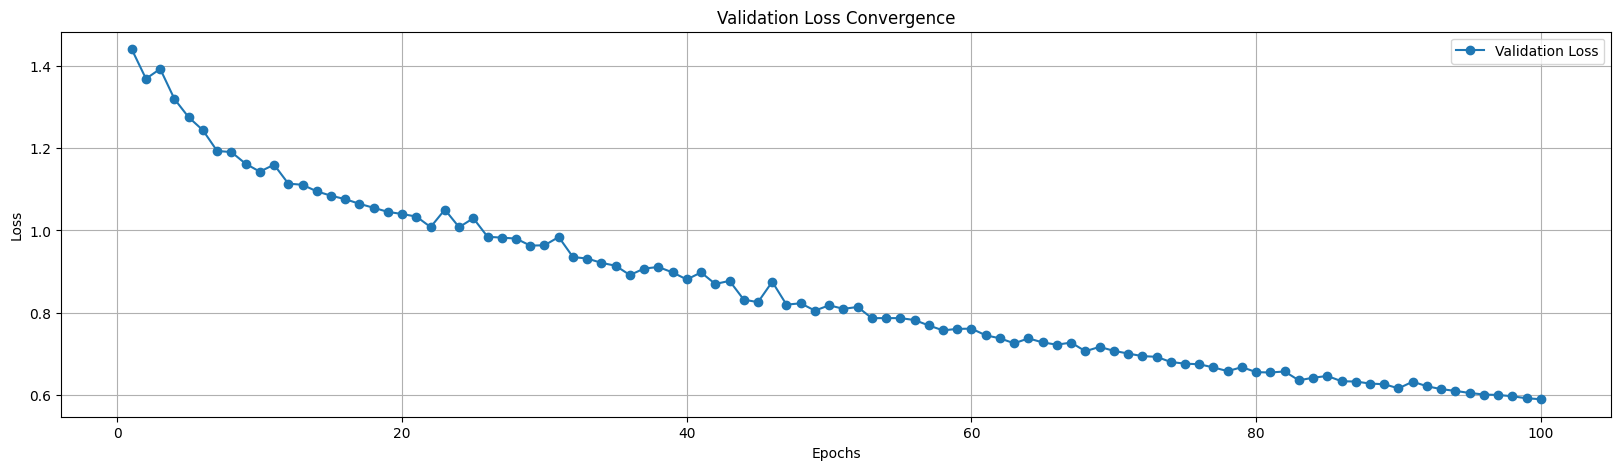

In [ ]:
log_path=os.path.join("/kaggle/working/runs/detect/train/results.csv")
train_data=pd.read_csv(log_path)

epochs=train_data["epoch"]
val_loss=train_data["val/box_loss"]

plt.figure(figsize=(20,5))
plt.plot(epochs,val_loss,marker='o',label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Validation Loss Convergence")
plt.legend()
plt.grid(True)
plt.show()

# **2. Predict solar panels using the trained model. Visualize the ground truth and predicted bounding boxes on 3-4 random samples from the test dataset. Use appropriate color schemes to differentiate between ground truth and predicted labels.**

In [ ]:
def get_yolo_format(file,height,width):
    box=[]
    for line in file.readlines():
        data=line.strip().split()
        class_id=int(data[0])
        x_center,y_center,bbox_w,bbox_h=map(float,data[1:])

        xmin=int((x_center-bbox_w/2)*width)
        ymin=int((y_center-bbox_h/2)*height)
        xmax=int((x_center+bbox_w/2)*width)
        ymax=int((y_center+bbox_h/2)*height)
        box.append([class_id,xmin,ymin,xmax,ymax])

    return box

In [ ]:
import cv2

def result_visualization(image_path,results):
    image=cv2.imread(image_path)
    image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    label_path=image_path.replace("/images/","/labels/").replace(".jpg",".txt")
    height,width,_=image.shape

    if os.path.exists(label_path):
        with open(label_path,"r") as file:
            bbox=get_yolo_format(file,height,width)

            for box in bbox:
                class_id,x1,y1,x2,y2=box
                cv2.rectangle(image,(x1,y1),(x2,y2),(0,255,0),1)
                cv2.putText(image,f"GT: {class_names[class_id]}",(x1,y1-5),cv2.FONT_HERSHEY_SIMPLEX,0.5,(0,255,0),1)

    for box in results.boxes:
        x1,y1,x2,y2=map(int,box.xyxy[0])
        conf=box.conf[0].item()
        class_id=int(box.cls[0])

        cv2.rectangle(image,(x1,y1),(x2,y2),(255,0,0),1)
        cv2.putText(image,f"Pred:{class_names[class_id]} ({conf:.2f})",(x2,y2+5),cv2.FONT_HERSHEY_SIMPLEX,0.5,(255,0,0),1)

    plt.figure(figsize=(8,8))
    plt.imshow(image)
    plt.axis("off")
    plt.show()


image 1/1 /kaggle/working/dataset/images/test/solarpanels_native_3__x0_5982_y0_13833_dxdy_416.jpg: 416x416 3 Class_0s, 18.5ms
Speed: 0.8ms preprocess, 18.5ms inference, 1.8ms postprocess per image at shape (1, 3, 416, 416)


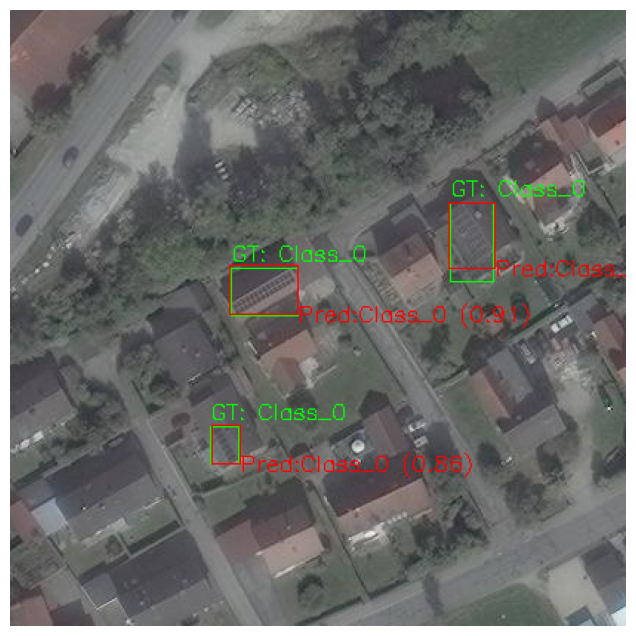


image 1/1 /kaggle/working/dataset/images/test/solarpanels_native_2__x0_1072_y0_10647_dxdy_416.jpg: 416x416 18 Class_0s, 19.1ms
Speed: 0.9ms preprocess, 19.1ms inference, 1.9ms postprocess per image at shape (1, 3, 416, 416)


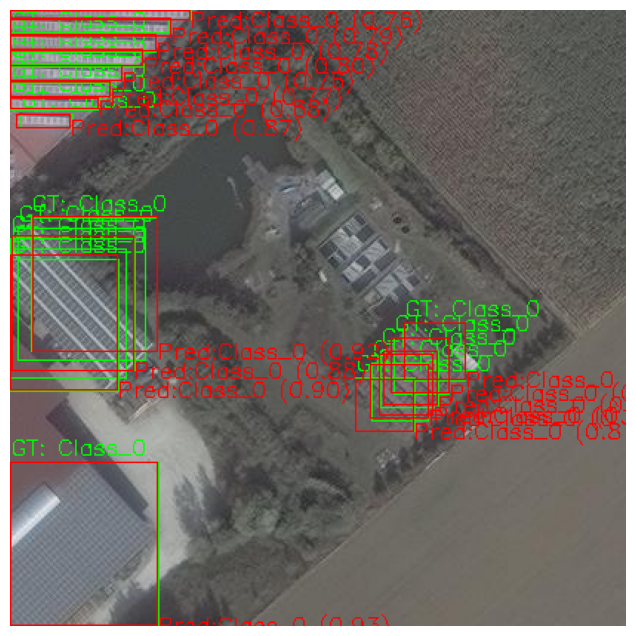


image 1/1 /kaggle/working/dataset/images/test/solarpanels_native_1__x0_1214_y0_3647_dxdy_416.jpg: 416x416 5 Class_0s, 21.0ms
Speed: 1.3ms preprocess, 21.0ms inference, 1.9ms postprocess per image at shape (1, 3, 416, 416)


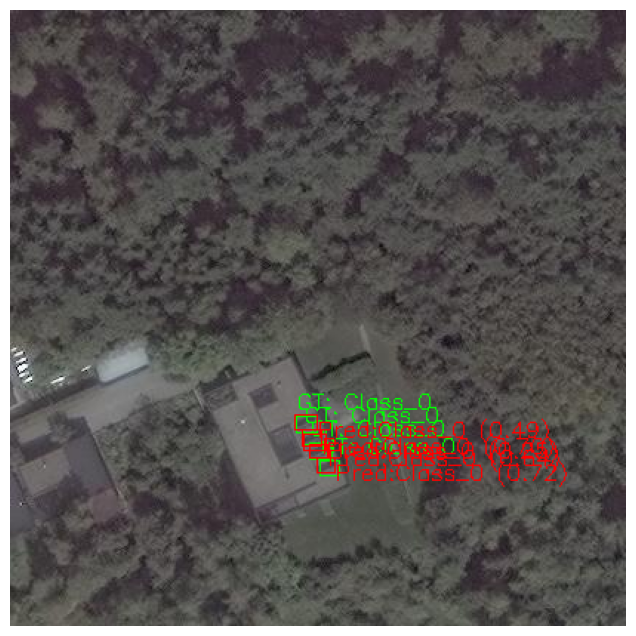


image 1/1 /kaggle/working/dataset/images/test/solarpanels_native_1__x0_3455_y0_13057_dxdy_416.jpg: 416x416 14 Class_0s, 20.2ms
Speed: 1.1ms preprocess, 20.2ms inference, 1.8ms postprocess per image at shape (1, 3, 416, 416)


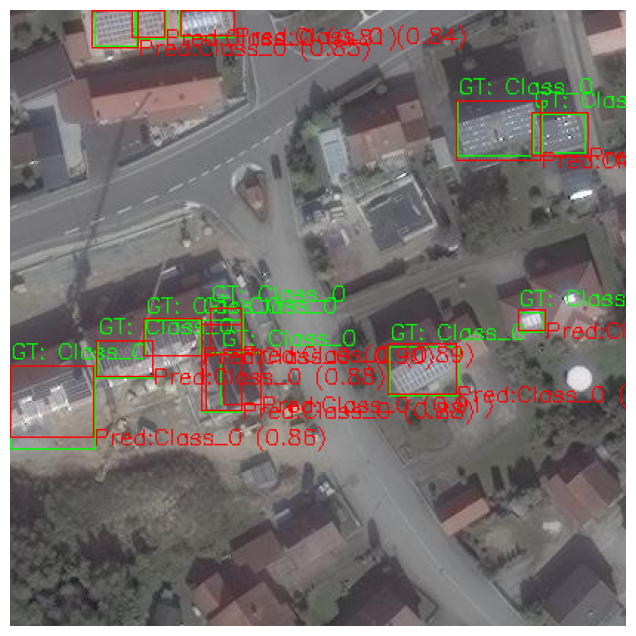

In [ ]:
import yaml
import random

model=YOLO("/kaggle/working/runs/detect/train/weights/best.pt")

with open("/kaggle/working/dataset/dataset.yaml", "r") as file:
    data_yaml=yaml.safe_load(file)

class_names=data_yaml["names"]
test_images_path="/kaggle/working/dataset/images/test"
test_images=[os.path.join(test_images_path,image_path) for image_path in os.listdir(test_images_path)]
random_images=random.sample(test_images,min(4,len(test_images)))

prediction=[]
for img_path in random_images:
    output=model(img_path)[0]
    prediction.append(output)
    result_visualization(img_path,output)

# **3.Use supervision.metrics functionality from supervision library to compute the following metrics.**

# 3. a. Compute mAP50 with supervision and compare with your implementation. What do you observe

In [ ]:
import supervision as sv
from supervision.metrics.detection import MeanAveragePrecision

In [ ]:
import numpy as np

def get_yolo_format(file,height,width):
    box,class_ids=[],[]
    for line in file.readlines():
        data=line.strip().split()
        class_id=int(data[0])
        x_center,y_center,bbox_w,bbox_h=map(float,data[1:])
        x_center*=width
        y_center*=height
        bbox_w*=width
        bbox_h*=height
        box.append([x_center,y_center,bbox_w,bbox_h])
        class_ids.append(class_id)
    return box,class_ids

def convert_to_xyxy(boxes):
    x_center,y_center,height,width=boxes
    xmin=x_center-(width/2)
    ymin=y_center-(height/2)
    xmax=x_center+(width/2)
    ymax=y_center+(height/2)
    return [xmin,ymin,xmax,ymax]

In [ ]:
def get_truth_predict_boxes(image_path,results):
    image=cv2.imread(image_path)
    image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    label_path=image_path.replace("/images/","/labels/").replace(".jpg",".txt")
    height,width,_=image.shape

    if os.path.exists(label_path):
        with open(label_path,"r") as file:
            actual_boxes,actual_class_ids=get_yolo_format(file,height,width)

    predict_boxes,predict_class_ids,predict_conf=[],[],[]
    for box in results.boxes:
        x1,y1,x2,y2=map(int,box.xyxy[0])
        class_id=int(box.cls[0])
        x_center=(x1+x2)/2
        y_center=(y1+y2)/2
        width=x2-x1
        height=y2-y1
        predict_boxes.append([x_center,y_center,width,height])
        predict_class_ids.append(class_id)
        predict_conf.append(box.conf[0].item())

    return (actual_boxes,actual_class_ids),(predict_boxes,predict_class_ids,predict_conf)

In [ ]:
def get_dic_classes(data):
    class_to_boxes={}
    for class_id,box in zip(data[1],data[0]):
        if class_id not in class_to_boxes:
            class_to_boxes[class_id]=[]
        class_to_boxes[class_id].append(box)

    return class_to_boxes

def modified_compute_mAP50(actual,predict,iou_threshold,method=None):

    classes_truth={}
    classes_predict={}
    for (img_path,output) in zip(actual,predict):
        truth_values,predict_values=get_truth_predict_boxes(img_path,output)
        classes_to_truth_boxes=get_dic_classes(truth_values)
        classes_to_predict_boxes=get_dic_classes(predict_values)

        for class_id in classes_to_truth_boxes.keys():
            if class_id not in classes_truth:
                classes_truth[class_id]=[]
            classes_truth[class_id].extend(list(classes_to_truth_boxes.values()))

        for class_id in classes_to_predict_boxes.keys():
            if class_id not in classes_predict:
                classes_predict[class_id]=[]
            classes_predict[class_id].extend(list(classes_to_predict_boxes.values()))

    average_precision=[]
    for class_id in classes_truth.keys():
        truth_boxes=classes_truth.get(class_id,[])
        predict_boxes=classes_predict.get(class_id,[])

        if not truth_boxes or not predict_boxes:
            continue
        if method=="Pascal_voc_11_point_interpolation":
            ap=pascal_voc_11_point_interpolation(truth_boxes,predict_boxes,iou_threshold)
        if method=="Coco_101_point_interpolation":
            ap=coco_101_point_interpolation(truth_boxes,predict_boxes,iou_threshold)
        if method=="Area_under_Precision_Recall_curve":
            ap=area_under_precision_recall_curve(truth_boxes,predict_boxes,iou_threshold)
        del truth_boxes,predict_boxes
        average_precision.append(ap)

    return np.mean(average_precision) if average_precision else 0

In [ ]:
import supervision as sv
from ultralytics import YOLO

def mAP50_supervision(model_path,images_path,label_path,data_yaml_path):
    def callback(image: np.ndarray)->sv.Detections:
        result = model(image)[0]
        return sv.Detections.from_ultralytics(result)

    dataset = sv.DetectionDataset.from_yolo(
        images_directory_path=images_path,
        annotations_directory_path=label_path,
        data_yaml_path=data_yaml_path
    )

    model=YOLO(model_path)
    mean_average_precision = sv.MeanAveragePrecision.benchmark(
        dataset=dataset,
        callback=callback
    )
    return mean_average_precision.map50

In [ ]:
test_images_path="/kaggle/working/dataset/images/test"
test_images=[os.path.join(test_images_path,image_path) for image_path in os.listdir(test_images_path)]
prediction=[]
for img_path in test_images:
    output=model(img_path)[0]
    prediction.append(output)


image 1/1 /kaggle/working/dataset/images/test/solarpanels_native_3__x0_6406_y0_10849_dxdy_416.jpg: 416x416 19 Class_0s, 21.6ms
Speed: 1.1ms preprocess, 21.6ms inference, 2.0ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /kaggle/working/dataset/images/test/solarpanels_native_3__x0_6740_y0_11883_dxdy_416.jpg: 416x416 6 Class_0s, 19.3ms
Speed: 0.9ms preprocess, 19.3ms inference, 1.8ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /kaggle/working/dataset/images/test/solarpanels_native_2__x0_714_y0_10614_dxdy_416.jpg: 416x416 78 Class_0s, 22.6ms
Speed: 0.8ms preprocess, 22.6ms inference, 2.2ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /kaggle/working/dataset/images/test/solarpanels_native_3__x0_8703_y0_14724_dxdy_416.jpg: 416x416 6 Class_0s, 24.9ms
Speed: 0.8ms preprocess, 24.9ms inference, 2.4ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /kaggle/working/dataset/images/test/solarpanels_native_3__x0_7713_y0_9939_dxdy_416.jpg: 416x

In [ ]:
test_path="/kaggle/working/dataset/images/test"
label_path="/kaggle/working/dataset/labels/test"
model_path="/kaggle/working/runs/detect/train/weights/best.pt"
data_path="/kaggle/working/dataset/dataset.yaml"
method1=mAP50_supervision(model_path,test_path,label_path,data_path)
method2=modified_compute_mAP50(random_images,prediction,0.5,"Pascal_voc_11_point_interpolation")
method3=modified_compute_mAP50(random_images,prediction,0.5,"Coco_101_point_interpolation")
method4=modified_compute_mAP50(random_images,prediction,0.5,"Area_under_Precision_Recall_curve")


0: 416x416 19 Class_0s, 18.9ms
Speed: 1.1ms preprocess, 18.9ms inference, 1.9ms postprocess per image at shape (1, 3, 416, 416)

0: 416x416 6 Class_0s, 19.9ms
Speed: 1.3ms preprocess, 19.9ms inference, 1.8ms postprocess per image at shape (1, 3, 416, 416)

0: 416x416 78 Class_0s, 18.4ms
Speed: 1.2ms preprocess, 18.4ms inference, 1.7ms postprocess per image at shape (1, 3, 416, 416)

0: 416x416 6 Class_0s, 18.5ms
Speed: 1.3ms preprocess, 18.5ms inference, 1.6ms postprocess per image at shape (1, 3, 416, 416)

0: 416x416 4 Class_0s, 18.3ms
Speed: 1.1ms preprocess, 18.3ms inference, 1.5ms postprocess per image at shape (1, 3, 416, 416)

0: 416x416 14 Class_0s, 19.3ms
Speed: 0.9ms preprocess, 19.3ms inference, 1.6ms postprocess per image at shape (1, 3, 416, 416)

0: 416x416 8 Class_0s, 18.2ms
Speed: 1.2ms preprocess, 18.2ms inference, 1.7ms postprocess per image at shape (1, 3, 416, 416)

0: 416x416 14 Class_0s, 2 Class_1s, 18.6ms
Speed: 1.3ms preprocess, 18.6ms inference, 1.7ms postproc

In [ ]:
dic={
    'Methods':["Supervision Library","Pascal_voc_11_point_interpolation","Coco_101_point_interpolation","Area_under_Precision_Recall_curve"],
    'mAP50_value':[method1,method2,method3,method4]
}
result=pd.DataFrame(dic).set_index('Methods')
result

,mAP50_value
Methods,
Supervision Library,0.945741
Pascal_voc_11_point_interpolation,0.000000
Coco_101_point_interpolation,0.000000
Area_under_Precision_Recall_curve,0.000000


# 3. b. Create a table of Precision, Recall and F1-scores where rows are IoU thresholds [0.1, 0.3, 0.5, 0.7, 0.9] and columns are confidence thresholds [0.1, 0.3, 0.5, 0.7, 0.9] (Hint use supervision.metrics.ConfusionMatrix to get the confusion matrix and get TP, FP and FN from it to compute the P, R and F-1)

In [ ]:
import numpy as np
import supervision as sv
from ultralytics import YOLO
from tabulate import tabulate

dataset = sv.DetectionDataset.from_yolo(
    images_directory_path="/kaggle/working/dataset/images/test",
    annotations_directory_path="/kaggle/working/dataset/labels/test",
    data_yaml_path="/kaggle/working/dataset/dataset.yaml"
)
model=YOLO("/kaggle/working/runs/detect/train/weights/best.pt")

def callback(image: np.ndarray) -> sv.Detections:
    result=model(image)[0]
    return sv.Detections.from_ultralytics(result)

confusion_matrix=sv.ConfusionMatrix.benchmark(
    dataset=dataset,
    callback=callback
)

print("Confusion Matrix:")
print(confusion_matrix.matrix)

iou_thresholds=[0.1,0.3,0.5,0.7,0.9]
confidence_thresholds = [0.1,0.3,0.5,0.7,0.9]

table=[]

for iou_threshold in iou_thresholds:
    for confidence_threshold in confidence_thresholds:
        confusion_matrix.iou_threshold=iou_threshold
        confusion_matrix.confidence_threshold=confidence_threshold

        matrix=confusion_matrix.matrix
        tp=np.diag(matrix).sum()
        fp=matrix.sum(axis=0) - tp
        fn=matrix.sum(axis=1) - tp

        precision=tp/(tp + fp.sum()) if (tp + fp.sum()) > 0 else 0
        recall=tp/(tp+fn.sum()) if (tp + fn.sum()) > 0 else 0
        f1_score=2*(precision*recall) / (precision+recall) if (precision+recall) > 0 else 0
        table.append([iou_threshold,confidence_threshold,precision,recall,f1_score])


0: 416x416 19 Class_0s, 18.5ms
Speed: 1.0ms preprocess, 18.5ms inference, 1.8ms postprocess per image at shape (1, 3, 416, 416)

0: 416x416 6 Class_0s, 19.0ms
Speed: 1.3ms preprocess, 19.0ms inference, 1.6ms postprocess per image at shape (1, 3, 416, 416)

0: 416x416 78 Class_0s, 18.4ms
Speed: 1.2ms preprocess, 18.4ms inference, 1.8ms postprocess per image at shape (1, 3, 416, 416)

0: 416x416 6 Class_0s, 18.3ms
Speed: 1.1ms preprocess, 18.3ms inference, 1.7ms postprocess per image at shape (1, 3, 416, 416)

0: 416x416 4 Class_0s, 18.5ms
Speed: 1.2ms preprocess, 18.5ms inference, 1.6ms postprocess per image at shape (1, 3, 416, 416)

0: 416x416 14 Class_0s, 20.6ms
Speed: 1.2ms preprocess, 20.6ms inference, 1.6ms postprocess per image at shape (1, 3, 416, 416)

0: 416x416 8 Class_0s, 18.0ms
Speed: 1.2ms preprocess, 18.0ms inference, 1.7ms postprocess per image at shape (1, 3, 416, 416)

0: 416x416 14 Class_0s, 2 Class_1s, 18.4ms
Speed: 1.0ms preprocess, 18.4ms inference, 1.6ms postproc

In [ ]:
headers=["IoU Threshold","Confidence Threshold","Precision","Recall","F1-Score"]
print(tabulate(table,headers=headers,tablefmt="grid"))

+-----------------+------------------------+-------------+----------+------------+
|   IoU Threshold |   Confidence Threshold |   Precision |   Recall |   F1-Score |
+=================+========================+=============+==========+============+
|             0.1 |                    0.1 |           0 |        0 |          0 |
+-----------------+------------------------+-------------+----------+------------+
|             0.1 |                    0.3 |           0 |        0 |          0 |
+-----------------+------------------------+-------------+----------+------------+
|             0.1 |                    0.5 |           0 |        0 |          0 |
+-----------------+------------------------+-------------+----------+------------+
|             0.1 |                    0.7 |           0 |        0 |          0 |
+-----------------+------------------------+-------------+----------+------------+
|             0.1 |                    0.9 |           0 |        0 |          0 |
+---